 # Comparison of PCN and BioPCN on MNIST with two large hidden (linear) layers

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pydove as dv

import numpy as np
import torch

from tqdm.notebook import tqdm
from functools import partial

from cpcn import LinearBioPCN, PCNetwork, load_mnist, Trainer, show_learning_curves

 ## Setup

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# for reproducibility
torch.manual_seed(123)

# get train, validation, and test loaders for MNIST
dataset = load_mnist(n_validation=1000, device=device)

 ## Train PCN

In [3]:
n_batches = 3000
dims = [784, 600, 600, 10]
z_it = 50
z_lr = 0.07
rho = 0.02
# rho = 0.0012

torch.manual_seed(123)

net = PCNetwork(
    dims,
    activation=lambda _: _,
    z_lr=z_lr,
    z_it=z_it,
    variances=1.0,
    constrained=True,
    rho=rho,
    bias=False,
)
net = net.to(device)

trainer = Trainer(net, dataset["train"], dataset["validation"])
trainer.peek_validation(every=10)
trainer.set_classifier("linear")

trainer.set_optimizer(torch.optim.SGD, lr=0.008)
# trainer.set_optimizer(torch.optim.Adam, lr=0.003)
# trainer.add_scheduler(partial(torch.optim.lr_scheduler.ExponentialLR, gamma=0.99))

results = trainer.run(n_batches=n_batches, progress=tqdm)

  0%|          | 0/3000 [00:00<?, ?it/s]

 ### Show PCN learning curves

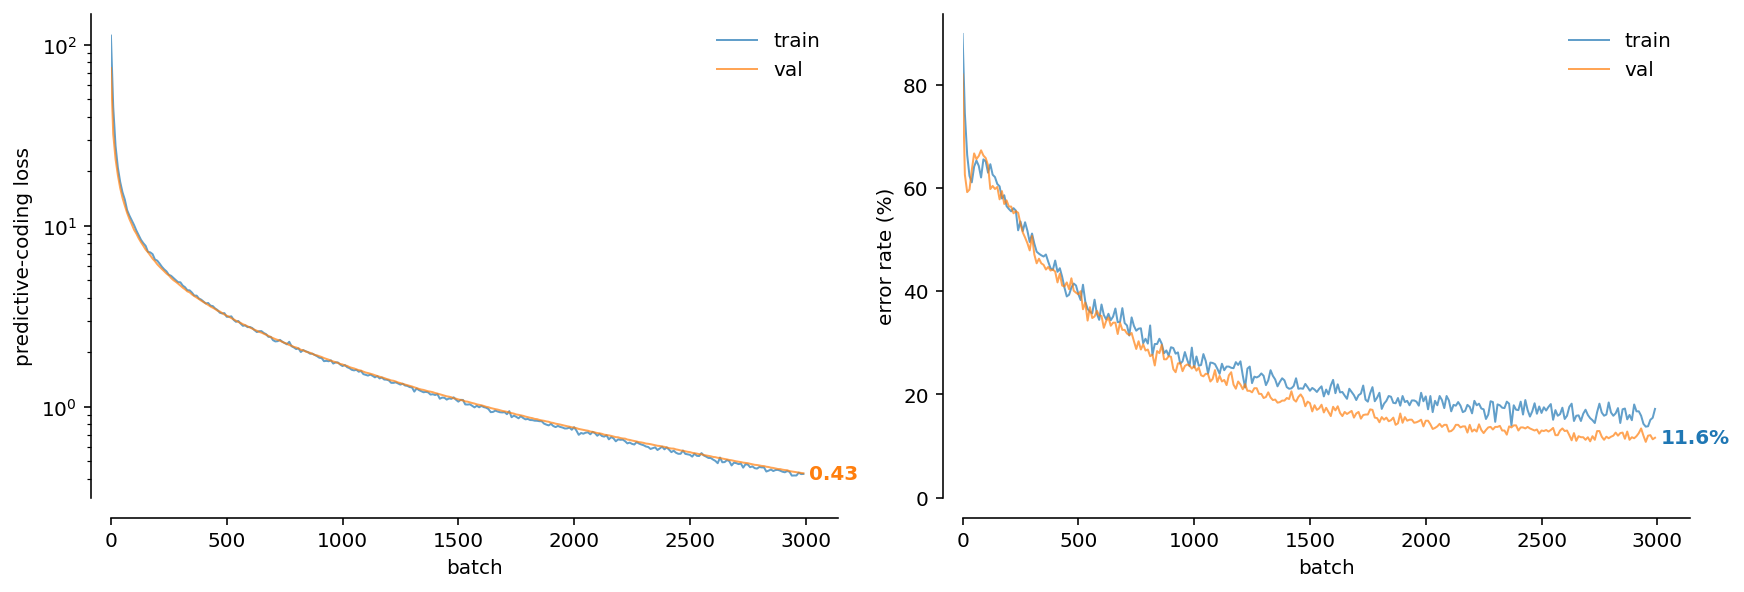

In [6]:
_ = show_learning_curves(results)

 ## Train BioPCN

In [8]:
z_it = 50
z_lr = 0.02
Q_lr_factor = 2.0

torch.manual_seed(123)

# match the PCN network
g_a = 0.5 * np.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * np.ones(len(dims) - 2)
g_b[0] *= 2

biopcn_net = LinearBioPCN(
    dims,
    z_lr=z_lr,
    z_it=z_it,
    g_a=g_a,
    g_b=g_b,
    c_m=0,
    l_s=g_b,
    rho=rho,
    bias_a=False,
    bias_b=False,
    q0_scale=np.sqrt(1 + dims[2] / dims[1]),
)
biopcn_net = biopcn_net.to(device)

biopcn_trainer = Trainer(biopcn_net, dataset["train"], dataset["validation"])
biopcn_trainer.peek_validation(every=10)
biopcn_trainer.set_classifier("linear")

# biopcn_trainer.set_optimizer(torch.optim.Adam, lr=0.004)
biopcn_trainer.set_optimizer(torch.optim.SGD, lr=0.008)
biopcn_trainer.set_lr_factor("Q", Q_lr_factor)
# biopcn_trainer.add_scheduler(partial(torch.optim.lr_scheduler.ExponentialLR, gamma=0.997))

biopcn_results = biopcn_trainer.run(n_batches=n_batches, progress=tqdm)

  0%|          | 0/3000 [00:00<?, ?it/s]

 ### Show BioPCN learning curves

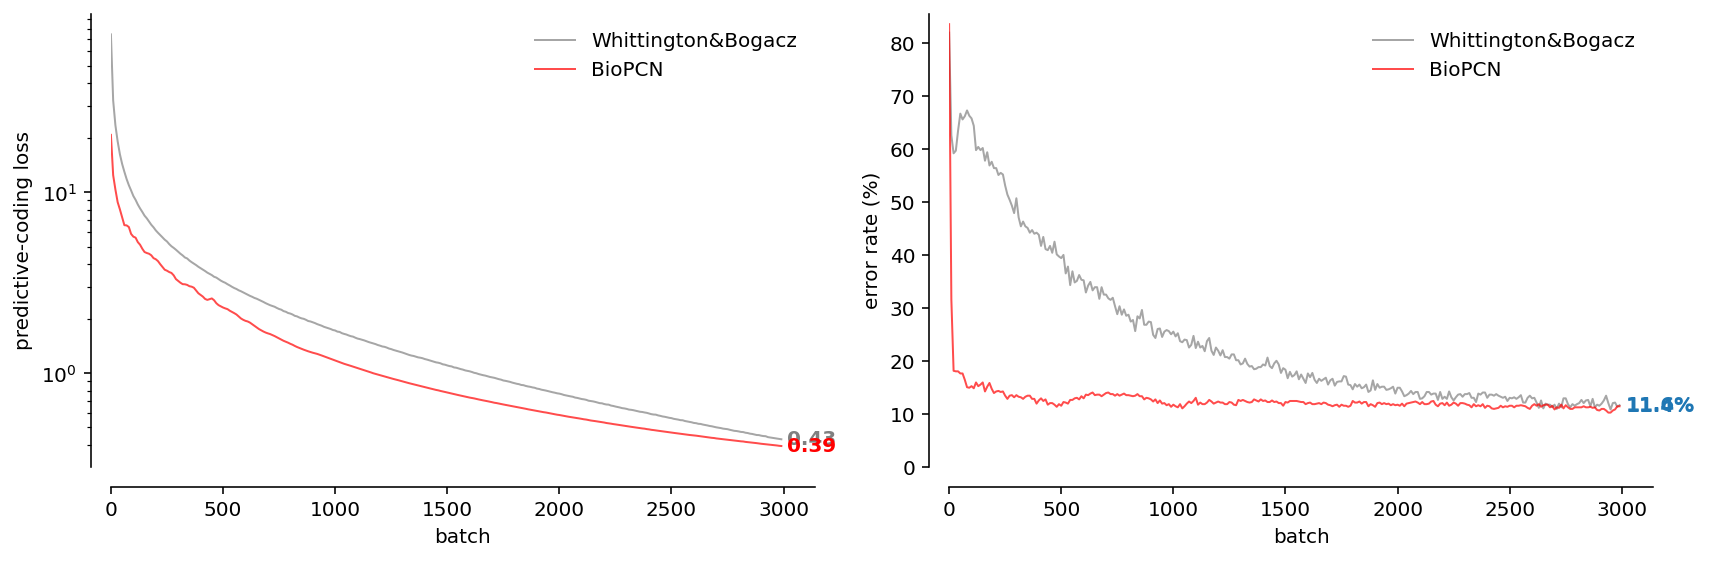

In [9]:
with dv.FigureManager(1, 2) as (_, axs):
    show_learning_curves(
        results,
        show_train=False,
        labels=("", "Whittington&Bogacz"),
        colors=("C0", "gray"),
        axs=axs,
    )
    show_learning_curves(
        biopcn_results,
        show_train=False,
        labels=("", "BioPCN"),
        colors=("C0", "red"),
        axs=axs,
    )